In [17]:
!pip install openai hcaptcha_challenger

In [18]:
import base64
import json
import os
from pathlib import Path
from typing import Literal

import dotenv
from IPython.display import JSON, Image
from matplotlib import pyplot as plt
from openai import OpenAI

from hcaptcha_challenger import ChallengeTypeEnum
from hcaptcha_challenger.helper import FloatRect, create_coordinate_grid
from hcaptcha_challenger.helper.visualize_attention_points import show_answer_points
from hcaptcha_challenger.models import ImageAreaSelectChallenge
from hcaptcha_challenger.models import ImageBinaryChallenge
from hcaptcha_challenger.models import ImageDragDropChallenge
from hcaptcha_challenger.tools import SpatialPointReasoner, SpatialPathReasoner, ImageClassifier

dotenv.load_dotenv()

True

In [19]:
# Define the bounding box for coordinate alignment
DEFAULT_BBOX = FloatRect(x=0, y=0, width=501, height=431)

MODEL = "kimi-k2.5"
THINKING_TYPE: Literal["enabled", "disabled"] = "disabled"

client = OpenAI(
    base_url=os.getenv("OPENAI_BASE_URL", "https://api.moonshot.cn/v1"),
    api_key=os.getenv("MOONSHOT_API_KEY", os.getenv("OPENAI_API_KEY"))
)

## Utils

In [20]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def build_messages(
        job_prompt_: str,
        input_image_path_: Path,
        system_prompt_: str | None = None,
        enable_helper: bool = True,
) -> list:
    messages_ = []

    if system_prompt_:
        messages_.append({"role": "system", "content": system_prompt_})

    user_message_content = [
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{encode_image(input_image_path_)}"},
        }
    ]

    if enable_helper:
        grid_divisions_path_ = input_image_path_.parent.joinpath(
            f"coordinate_grid_{input_image_path_.name}"
        )
        grid_divisions_image_ = create_coordinate_grid(input_image_path_, DEFAULT_BBOX)
        plt.imsave(str(grid_divisions_path_.resolve()), grid_divisions_image_)
        user_message_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{encode_image(grid_divisions_path_)}"},
            }
        )

    # Create content with only the image
    # When the model performs inference, the image will also be converted into the corresponding Image Token.
    # When the context of a dialogue is long, the model may focus on the backward Prompt.
    # Therefore, when writing Prompt, you can say that the instructions are placed at the end
    # and the images are placed at the head, so that the model can pay more attention to the instructions,
    # thereby improving the effect of the instructions following.
    user_message_content.append({"type": "text", "text": job_prompt_})

    user_message = {"role": "user", "content": user_message_content}

    messages_.append(user_message)

    return messages_


## Image Classifier

In [21]:
job_prompt = f"""
Task:
Solve the challenge, use [0,0] ~ [2,2] to locate 9grid, output the coordinates of the correct answer as JSON.

Please output your response in the following JSON format:
{json.dumps(ImageBinaryChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_label_binary_filepath = Path("assets/image_label_binary/20250817200551586876_0_challenge_view.png")
completion_image_label_binary = client.chat.completions.create(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_label_binary_filepath,
        ImageClassifier.description,
        enable_helper=False
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)
challenge_result_image_label_binary = completion_image_label_binary.choices[0].message.content

JSON(completion_image_label_binary.model_dump())

<IPython.core.display.JSON object>

[BoundingBoxCoordinate(box_2d=[1, 1]), BoundingBoxCoordinate(box_2d=[2, 2])]


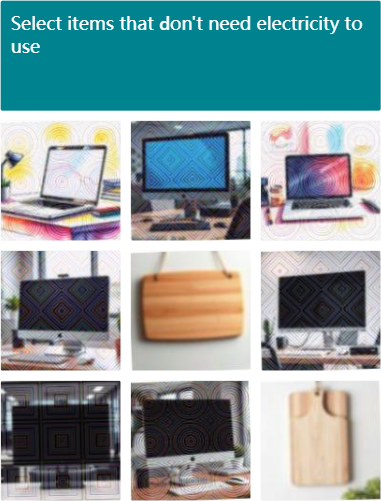

In [22]:
final_answer = ImageBinaryChallenge(**json.loads(completion_image_label_binary.choices[0].message.content))
print(final_answer.coordinates)
Image(image_label_binary_filepath)

## Spatial Point Reasoning (`IMAGE_LABEL_SINGLE_SELECT`)

In [23]:
job_prompt = f"""
**JobType:** {ChallengeTypeEnum.IMAGE_LABEL_SINGLE_SELECT.value}

Please output your response in the following JSON format:
{json.dumps(ImageAreaSelectChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_label_area_select_filepath_1 = Path("assets/image_label_area_select/20250426225911341786_0_challenge_view.png")

completion_image_label_area_select_1 = client.chat.completions.create(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_label_area_select_filepath_1,
        SpatialPointReasoner.description,
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)

JSON(completion_image_label_area_select_1.model_dump())

<IPython.core.display.JSON object>

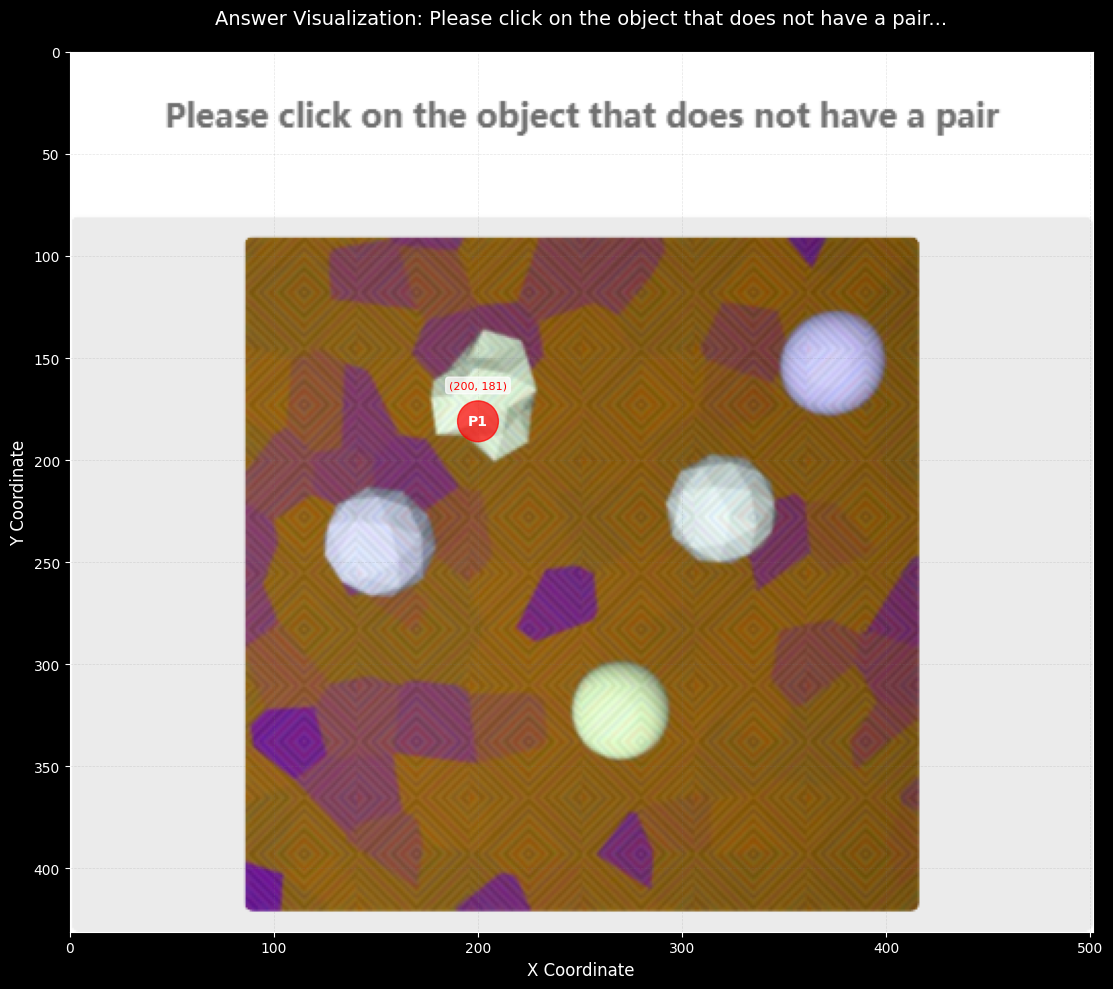

In [24]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_label_area_select_filepath_1,
    ImageAreaSelectChallenge(**json.loads(completion_image_label_area_select_1.choices[0].message.content)),
    DEFAULT_BBOX,
    show_plot=True,
)

## Spatial Point Reasoning (`IMAGE_LABEL_MULTI_SELECT_`)

In [25]:
job_prompt = f"""
**JobType:** {ChallengeTypeEnum.IMAGE_LABEL_MULTI_SELECT.value}

Please output your response in the following JSON format:
{json.dumps(ImageAreaSelectChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_label_area_select_filepath_2 = Path("assets/image_label_area_select/20250818003234074379_0_challenge_view.png")

completion_image_label_area_select_2 = client.chat.completions.create(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_label_area_select_filepath_2,
        SpatialPointReasoner.description,
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)

JSON(completion_image_label_area_select_2.model_dump())

<IPython.core.display.JSON object>

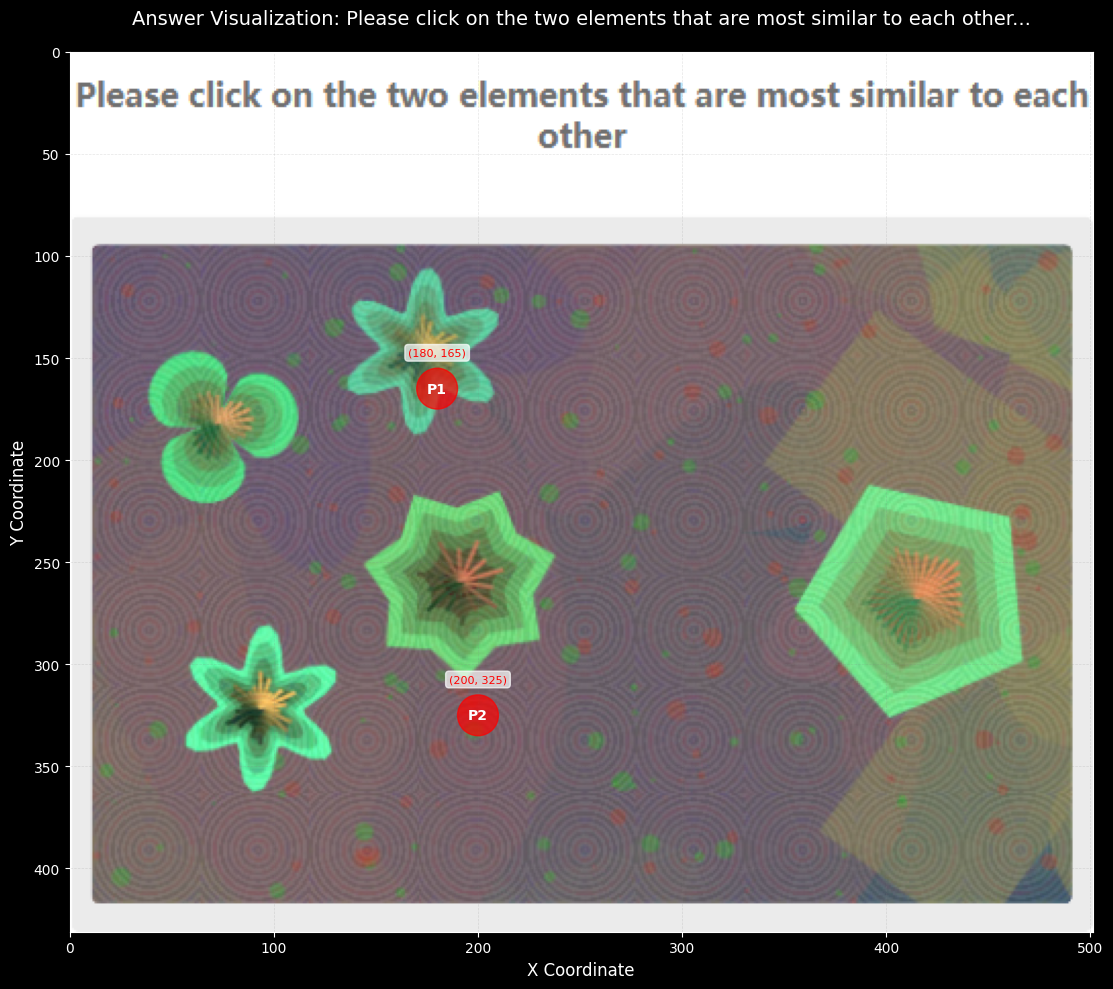

In [26]:
# Visualize the answer on the actual image
result_2 = show_answer_points(
    image_label_area_select_filepath_2,
    ImageAreaSelectChallenge(**json.loads(completion_image_label_area_select_2.choices[0].message.content)),
    DEFAULT_BBOX,
    show_plot=True,
)

## Spatial Path Reasoning (`IMAGE_DRAG_SINGLE`)

In [27]:
job_prompt = f"""
**JobType:** {ChallengeTypeEnum.IMAGE_DRAG_SINGLE.value}

Please output your response in the following JSON format:
{json.dumps(ImageDragDropChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_drag_drop_single_single_filepath = Path("assets/image_drag_drop/20250717190455891095_0_challenge_view.png")

completion_image_drag_drop_single = client.chat.completions.parse(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_single_filepath,
        SpatialPathReasoner.description,
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)

JSON(completion_image_drag_drop_single.model_dump())

<IPython.core.display.JSON object>

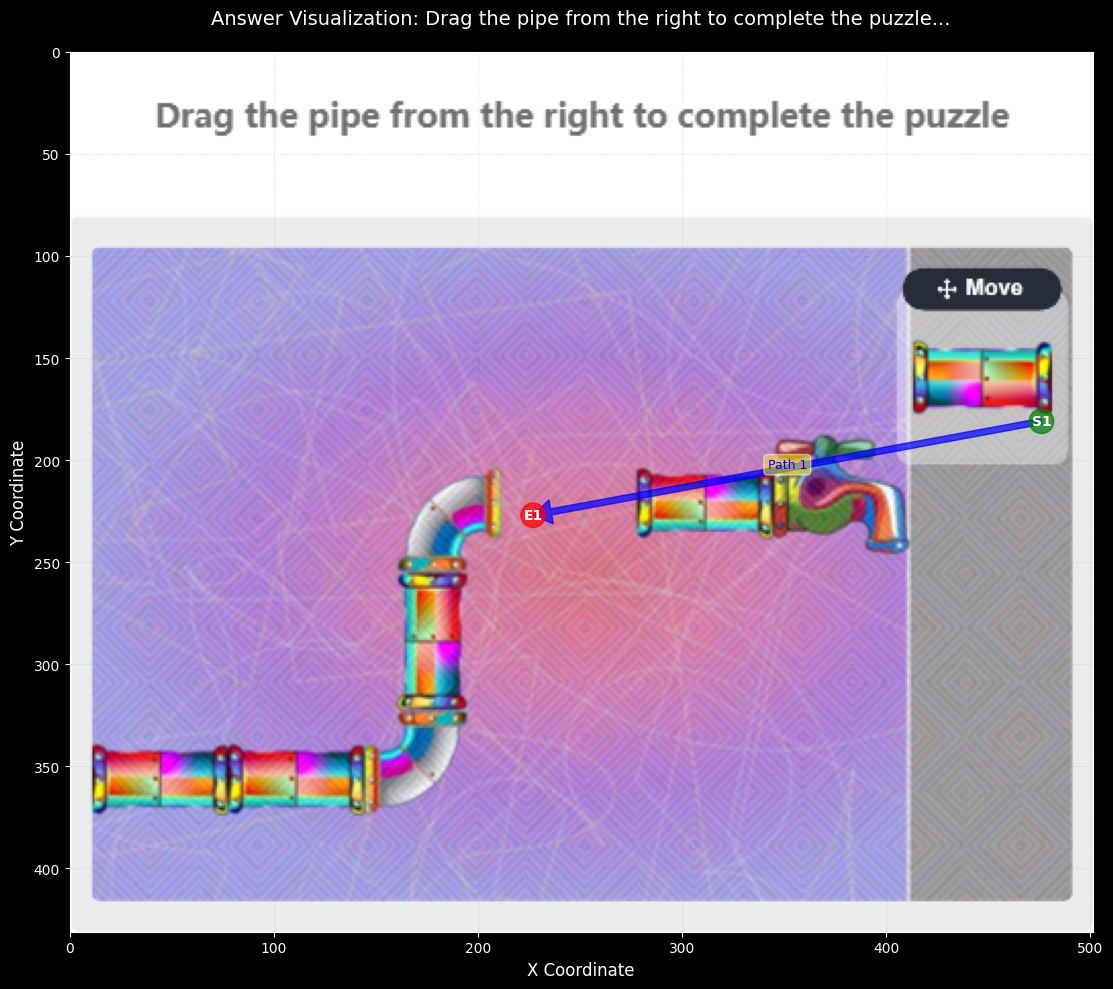

In [28]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_single_filepath,
    ImageDragDropChallenge(**json.loads(completion_image_drag_drop_single.choices[0].message.content)),
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)

## Spatial Path Reasoning (`IMAGE_DRAG_MULTI`)

In [36]:
job_prompt = f"""
**JobType:** {ChallengeTypeEnum.IMAGE_DRAG_MULTI.value}

Please output your response in the following JSON format:
{json.dumps(ImageDragDropChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_drag_drop_single_multi_filepath = Path("assets/image_drag_drop/20250818003210373861_0_challenge_view.png")

completion_image_drag_drop_multi = client.chat.completions.parse(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_multi_filepath,
        SpatialPathReasoner.description,
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)

JSON(completion_image_drag_drop_multi.model_dump())

<IPython.core.display.JSON object>

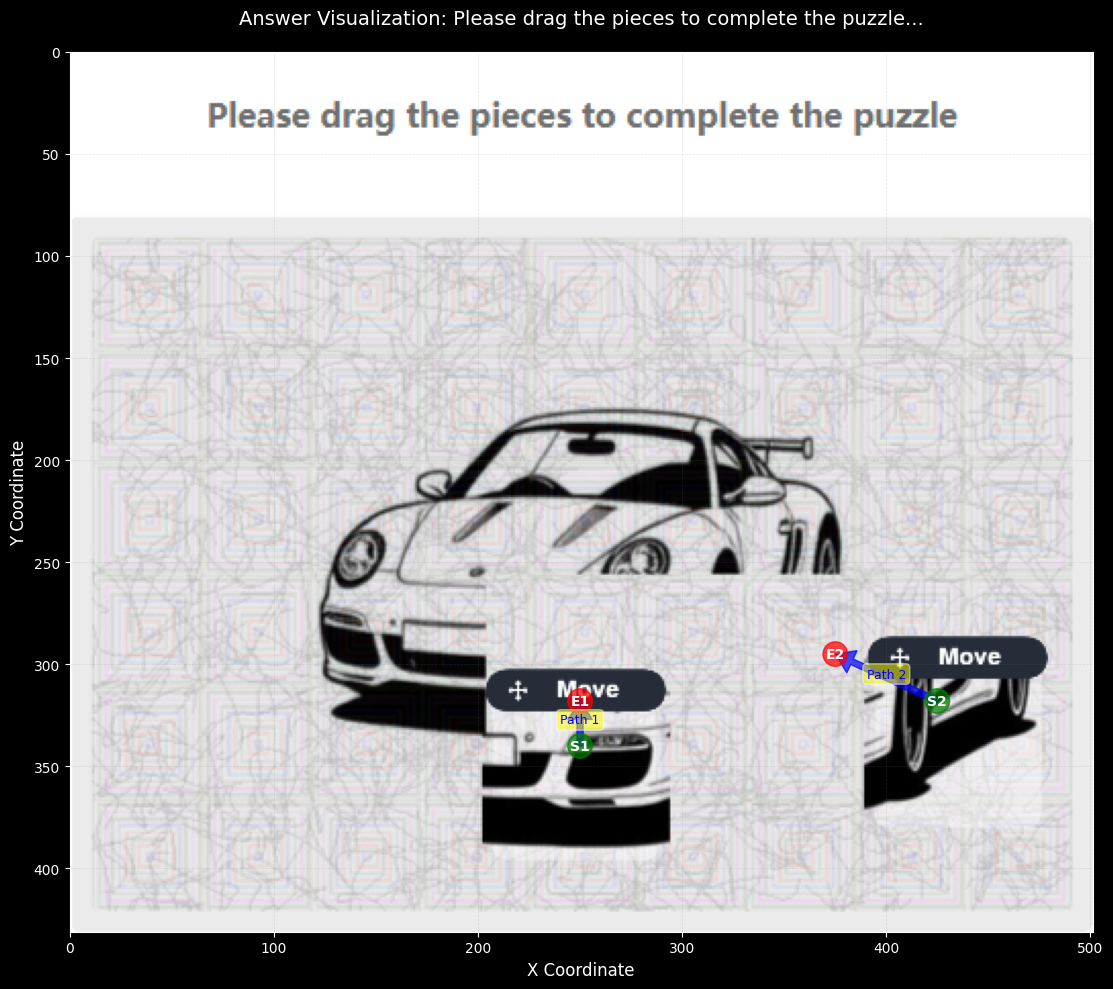

In [37]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_multi_filepath,
    ImageDragDropChallenge(**json.loads(completion_image_drag_drop_multi.choices[0].message.content)),
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)

## Spatial Path Reasoning (`IMAGE_DRAG_MULTI:CHALLENGE`)

In [31]:
job_prompt = f"""
**JobType:** {ChallengeTypeEnum.IMAGE_DRAG_MULTI.value}

Please output your response in the following JSON format:
{json.dumps(ImageDragDropChallenge.model_json_schema(), indent=2, ensure_ascii=False)}
"""

image_drag_drop_single_multi_filepath_2 = Path("assets/image_drag_drop/single_9.png")

completion_image_drag_drop_multi_2 = client.chat.completions.parse(
    model=MODEL,
    messages=build_messages(
        job_prompt,
        image_drag_drop_single_multi_filepath_2,
        SpatialPathReasoner.description,
    ),
    response_format={"type": "json_object"},
    extra_body={"thinking": {"type": THINKING_TYPE}}
)

JSON(completion_image_drag_drop_multi_2.model_dump())

<IPython.core.display.JSON object>

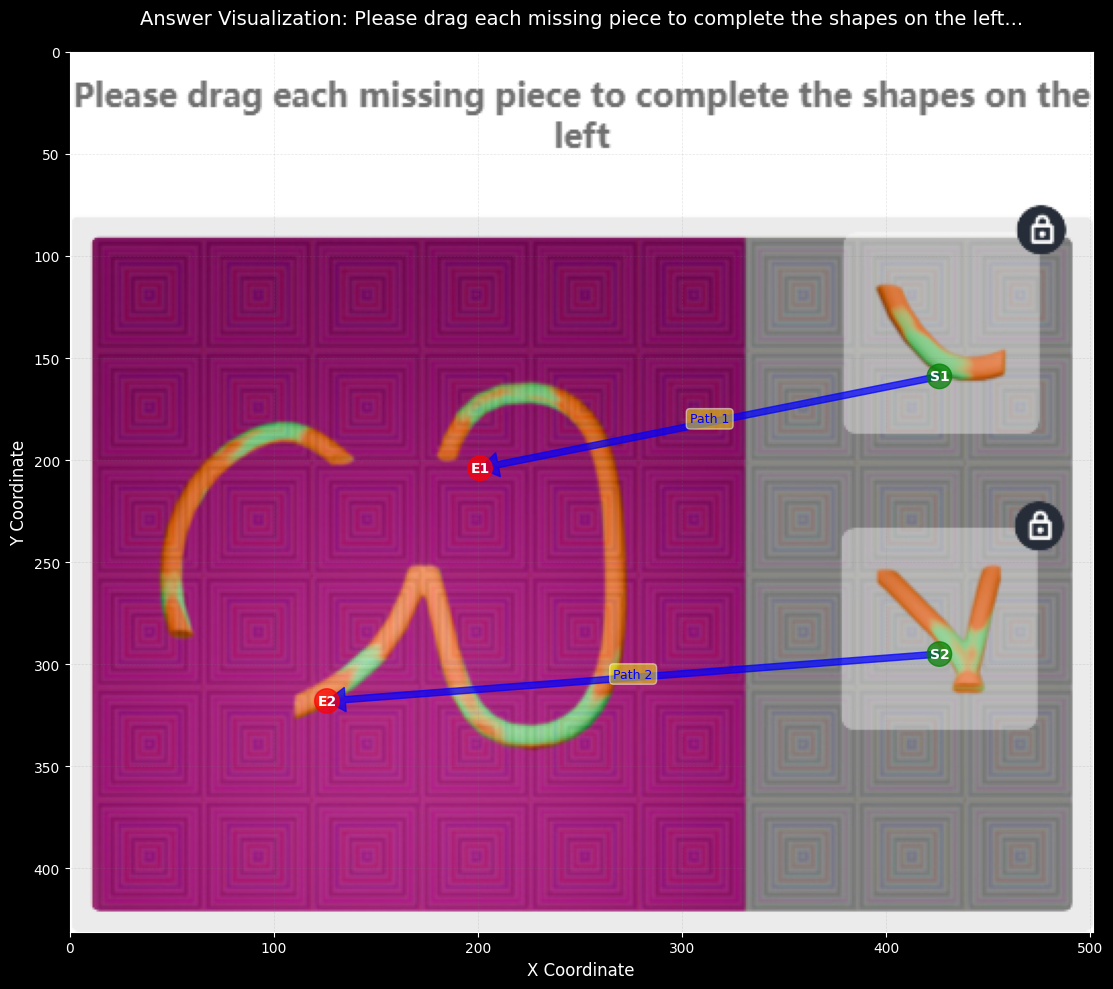

In [32]:
# Visualize the answer on the actual image
result = show_answer_points(
    image_drag_drop_single_multi_filepath_2,
    ImageDragDropChallenge(**json.loads(completion_image_drag_drop_multi_2.choices[0].message.content)),
    DEFAULT_BBOX,
    show_plot=True,
    path_color='blue',
    arrow_width=3,
    alpha=0.7
)